 에너지 Loss 분석을 위한 특징 데이터셋 적재

In [8]:
import numpy as np
import pandas as pd
from pyspark.sql import SparkSession
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler, MinMaxScaler

spark = SparkSession.builder.getOrCreate()
data = spark.read.orc("hdfs://nameserver/apps/spark/warehouse/cs_daily_features")

# 특징 데이터셋 스키마 및 일부 데이터
data.printSchema()
data.show(5)

df = data.toPandas()

# 학습 입력 컬럼
input_cols = df.columns[2:].tolist()
dcu_cols = df.columns[1]

# DCU ID를 Integer 라벨로 변환
le = LabelEncoder()
le.fit(df[dcu_cols])
df["dcu_label"] = le.transform(df[dcu_cols])

# Integer 라벨을 이진 벡터로 표현
ohe = OneHotEncoder()
x = ohe.fit_transform(df.dcu_label.values.reshape(-1,1)).toarray()
dfOneHot = pd.DataFrame(x, columns = ["dcu_"+str(int(i)) for i in range(x.shape[1])]) 
df = pd.concat([df, dfOneHot], axis=1)

# 데이터 정규화
scaler = MinMaxScaler()
scaler.fit(df[input_cols])
df[input_cols]= scaler.transform(df[input_cols])

# one hot encoded columns 추가
input_cols.extend(dfOneHot.columns)
#df.head()

root
 |-- LP_METER_ID: string (nullable = true)
 |-- LP_DCU_ID: string (nullable = true)
 |-- daily_20191206: double (nullable = true)
 |-- daily_20191207: double (nullable = true)
 |-- daily_20191208: double (nullable = true)
 |-- daily_20191209: double (nullable = true)
 |-- daily_20191210: double (nullable = true)
 |-- daily_20191211: double (nullable = true)
 |-- daily_20191212: double (nullable = true)
 |-- daily_20191213: double (nullable = true)
 |-- daily_20191214: double (nullable = true)
 |-- daily_20191215: double (nullable = true)
 |-- daily_20191216: double (nullable = true)
 |-- daily_20191217: double (nullable = true)
 |-- daily_20191218: double (nullable = true)
 |-- daily_20191219: double (nullable = true)
 |-- daily_20191220: double (nullable = true)
 |-- daily_20191221: double (nullable = true)
 |-- daily_20191222: double (nullable = true)
 |-- daily_20191223: double (nullable = true)
 |-- daily_20191224: double (nullable = true)
 |-- daily_20191225: double (nullable

+-----------+----------+---------------+----------------+--------------+--------------+--------------+---------------+----------------+---------------+----------------+--------------+--------------+--------------+---------------+---------------+---------------+--------------+--------------+--------------+--------------+--------------+---------------+---------------+---------------+---------------+---------------+--------------+--------------+--------------+--------------+---------------+---------------+--------------+--------------+--------------+--------------+---------------+--------------+--------------+--------------+---------------+---------------+---------------+--------------+--------------+--------------+---------------+---------------+---------------+--------------+--------------+---------------+--------------+--------------+---------------+---------------+--------------+--------------+---------------+---------------+---------------+--------------+--------------+--------------

비지도 머신러닝 알고리즘 적용 및 전력 사용 이상 미터 라벨링

In [2]:
# DBSCAN
from sklearn.cluster import DBSCAN

dbscan = DBSCAN(eps=2.2, min_samples=6)
df["anomaly"] = dbscan.fit_predict(df[input_cols])
print("---- DBSCAN ---")
#print("전력 사용이 의심되는 미터의 수 = " + str(len(df[["LP_METER_ID","anomaly"]][df["anomaly"]==-1])))
#df[["LP_METER_ID","anomaly"]][df["anomaly"]==-1]
anomaly = df.loc[df['anomaly']==-1]
anomaly_index_dbscan = list(anomaly.index)
anomaly_id_list_dbscan = df["LP_METER_ID"].iloc[anomaly_index_dbscan].tolist()
#print("전력 사용이 의심되는 미터 목록")
print(anomaly_id_list_dbscan)

# Spark iForest 
from pyspark_iforest.ml.iforest import *
from pyspark.sql.types import *
from pyspark.sql import functions as Fn
from pyspark.sql.functions import col, lit
from pyspark.ml.feature import StringIndexer, OneHotEncoderEstimator, VectorAssembler, MinMaxScaler
from pyspark.ml import Pipeline
from pyspark.mllib.evaluation import BinaryClassificationMetrics
from pyspark.ml.linalg import Vectors, VectorUDT
list_to_vector_udf = Fn.udf(lambda l: Vectors.dense(l), VectorUDT())

# DCU ID를 Integer 라벨로 변환
dcuIndexer = StringIndexer().setInputCol("LP_DCU_ID").setOutputCol("dcu_indexed")
dcuIndexed = dcuIndexer.fit(data).transform(data)

# Integer 라벨을 이진 벡터로 표현
encoder = OneHotEncoderEstimator().setInputCols(["dcu_indexed"]).setOutputCols(["dcu_enc"])
encoded = encoder.fit(dcuIndexed).transform(dcuIndexed)

inputCols = data.columns[2:]
inputCols.extend(["dcu_enc"])

assembler = VectorAssembler().setInputCols(inputCols).setOutputCol("features")
assembled = assembler.transform(encoded)
assembled = assembled.withColumn('vectorized_features', list_to_vector_udf("features"))
assembled = assembled.drop("features")
assembled = assembled.withColumn("features", col("vectorized_features")).drop("vectorized_features")

seed = 1234
iForest = IForest().setMaxFeatures(1).setMaxSamples(1).setBootstrap(False).setSeed(seed).setNumTrees(100).setMaxDepth(50)
model = iForest.fit(assembled)
predictions = model.transform(assembled)
print("---- Spark iForest ---")
#print("전력 사용이 의심되는 미터의 수 = " + str(model.summary.numAnomalies))
#predictions.where(col("prediction") == "1").select("LP_METER_ID","LP_DCU_ID", "anomalyScore", "prediction").show(25)
anomaly_id = predictions.filter(col("prediction") == 1.0).select("LP_METER_ID")
anomaly_id_list_spark_if = [ row["LP_METER_ID"] for row in anomaly_id.collect()]
#print("전력 사용이 의심되는 미터 목록")
print(anomaly_id_list_spark_if)

# Scikit-learn Isolation Forest
from sklearn.ensemble import IsolationForest
df = data.toPandas()

# 학습 입력 컬럼
input_cols = df.columns[2:].tolist()
dcu_cols = df.columns[1]

# DCU ID를 Integer 라벨로 변환
le = LabelEncoder()
le.fit(df[dcu_cols])
df["dcu_label"] = le.transform(df[dcu_cols])

# Integer 라벨을 이진 벡터로 표현
ohe = OneHotEncoder()
x = ohe.fit_transform(df.dcu_label.values.reshape(-1,1)).toarray()
dfOneHot = pd.DataFrame(x, columns = ["dcu_"+str(int(i)) for i in range(x.shape[1])]) 
df = pd.concat([df, dfOneHot], axis=1)

# one hot encoded columns 추가
input_cols.extend(dfOneHot.columns)

iforest = IsolationForest(n_estimators=100, max_samples=1.0, contamination=0.0963, max_features=1.0,
                          random_state=1234)
iforest.fit(df[input_cols])

df["scores"] = iforest.decision_function(df[input_cols])
df["anomaly"] = iforest.predict(df[input_cols])
print("--- Scikit-learn  Isolation Forest ---")
#print("전력 사용이 의심되는 미터의 수 = " + str(len(df[["LP_METER_ID","scores","anomaly"]][df["anomaly"]==-1])))
df[["LP_METER_ID","LP_DCU_ID", "scores","anomaly"]][df["anomaly"]==-1].sort_values("scores")
# 기본적으로 anomaly가 -1인 경우 anomalies
anomaly = df.loc[df['anomaly']==-1]
anomaly_index_sklearn_if = list(anomaly.index)
anomaly_id_list_sklearn_if = df["LP_METER_ID"].iloc[anomaly_index_sklearn_if].tolist()
#print("전력 사용이 의심되는 미터 목록")
print(anomaly_id_list_sklearn_if)

# 전력 사용 이상 미터
anomaly_id_list = list(set(anomaly_id_list_spark_if + anomaly_id_list_sklearn_if + anomaly_id_list_dbscan))
print("--- 최종 전력 사용 이상 미터 ---")
print(anomaly_id_list)

---- DBSCAN ---
['99260000364', '99260000214', '99260000321', '99260000390', '99260000322', '99260000268', '99260000147', '99260000188', '99260000106', '99260000014', '99260000478', '99260000191', '99260000361']
---- Spark iForest ---
['99260000364', '99260000214', '99260000390', '99260000322', '99260000446', '99260000127', '99260000268', '99260000188', '99260000106', '99260000014', '99260000478', '99260000191', '99260000361']
--- Scikit-learn  Isolation Forest ---
['99260000214', '99260000321', '99260000390', '99260000322', '99260000127', '99260000268', '99260000147', '99260000188', '99260000106', '99260000014', '99260000478', '99260000191', '99260000361']
--- 최종 전력 사용 이상 미터 ---
['99260000478', '99260000147', '99260000106', '99260000322', '99260000364', '99260000321', '99260000268', '99260000127', '99260000390', '99260000014', '99260000446', '99260000361', '99260000214', '99260000191', '99260000188']


딥러닝 기반 딥 오토인코더 기반 에너지 Loss 탐지

(108, 246) train samples
(27, 246) test samples
Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 246)]             0         
_________________________________________________________________
dense (Dense)                (None, 28)                6916      
_________________________________________________________________
dense_1 (Dense)              (None, 14)                406       
_________________________________________________________________
dense_2 (Dense)              (None, 7)                 105       
_________________________________________________________________
dense_3 (Dense)              (None, 14)                112       
_________________________________________________________________
dense_4 (Dense)              (None, 28)                420       
_________________________________________________________________
dense_5 (Dens

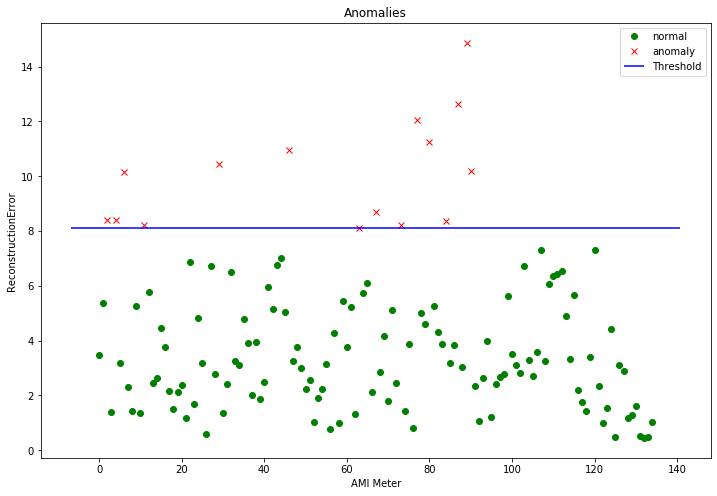

--- Deep Autoencoder ---
['99260000273', '99260000364', '99260000214', '99260000430', '99260000390', '99260000322', '99260000268', '99260000147', '99260000188', '99260000106', '99260000014', '99260000438', '99260000478', '99260000191', '99260000361']


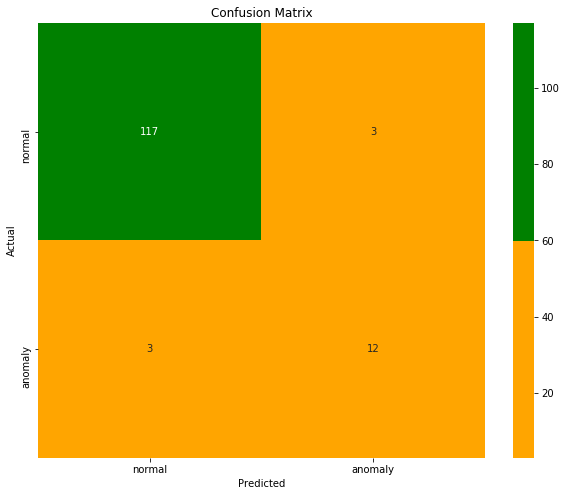

--- 에너지 Loss 탐지율 @ 라벨 1에 대한 f1-score ---
              precision    recall  f1-score   support

           0       0.97      0.97      0.97       120
           1       0.80      0.80      0.80        15

    accuracy                           0.96       135
   macro avg       0.89      0.89      0.89       135
weighted avg       0.96      0.96      0.96       135

0.8875


In [3]:
# Deep Autoencoder
import tensorflow.keras
from tensorflow.keras import optimizers, losses, regularizers
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Input, Dropout, LSTM
from tensorflow.keras.optimizers import RMSprop, Adam, Nadam
from tensorflow.keras.callbacks import TensorBoard

import sklearn
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, roc_auc_score, classification_report
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, MinMaxScaler
from sklearn.manifold import TSNE

import seaborn as sns
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
#%matplotlib inline
import tensorflow 
import sys

labels = ["normal", "anomaly"]
# 실제 및 예측 라벨
def draw_confusion_matrix(y, ypred):
    matrix = confusion_matrix(y, ypred)
    plt.figure(figsize=(10, 8))
    colors=[ "orange","green"]
    #sns.heatmap(matrix, xticklabels=self.labels, yticklabels=self.labels, cmap=colors, annot=True, fmt="d")
    sns.heatmap(matrix, xticklabels=labels, yticklabels=labels, cmap=colors, annot=True, fmt="d")
    plt.title("Confusion Matrix")
    plt.ylabel('Actual')
    plt.xlabel('Predicted')
    plt.show()
    
# reconstruction error에 따른 anomaly 
def draw_anomaly(y, error, threshold):
    groupsDF = pd.DataFrame({'error': error, 'true': y}).groupby('true')
    figure, axes = plt.subplots(figsize=(12, 8))
    for name, group in groupsDF:
        axes.plot(group.index, group.error, marker='x' if name == 1 else 'o', linestyle='',\
            color='r' if name == 1 else 'g', label="anomaly" if name == 1 else "normal")
    axes.hlines(threshold, axes.get_xlim()[0], axes.get_xlim()[1], colors="b", zorder=100, label='Threshold')
    axes.legend()
        
    plt.title("Anomalies")
    plt.ylabel("ReconstructionError")
    plt.xlabel("AMI Meter")
    plt.show()
    
# 데이터 포인트들의 reconstruction error
def draw_error(error, threshold):
    plt.plot(error, marker='o', ms=3.5, linestyle='', label='Point')
    plt.hlines(threshold, xmin=0, xmax=len(error)-1, colors="b", zorder=100, label='Threshold')
    plt.legend()
    plt.title("Reconstruction error")
    plt.ylabel("Error")
    plt.xlabel("Data")
    plt.show()

df = data.toPandas()

# 학습 입력 컬럼
input_cols = df.columns[2:].tolist()
dcu_cols = df.columns[1]

# DCU ID를 Integer 라벨로 변환
le = LabelEncoder()
le.fit(df[dcu_cols])
df["dcu_label"] = le.transform(df[dcu_cols])

# Integer 라벨을 이진 벡터로 표현
ohe = OneHotEncoder()
x = ohe.fit_transform(df.dcu_label.values.reshape(-1,1)).toarray()
dfOneHot = pd.DataFrame(x, columns = ["dcu_"+str(int(i)) for i in range(x.shape[1])]) 
df = pd.concat([df, dfOneHot], axis=1)

# 데이터 정규화
scaler = MinMaxScaler()
scaler.fit(df[input_cols])
df[input_cols]= scaler.transform(df[input_cols])

# one hot encoded columns 추가
input_cols.extend(dfOneHot.columns)

# 전력 사용 이상 미터 라벨링
y_anomalies = []
for id in df.LP_METER_ID.values.tolist():
    if id in anomaly_id_list:
        y_anomalies.append(1)
    else: y_anomalies.append(0)
df["anomalies"] = y_anomalies
df["LP_METER_ID"][df["anomalies"]==1]

x_train, x_test, y_train, y_test = train_test_split(df[input_cols], df["anomalies"], test_size=0.2, random_state=42)
print(x_train.shape, 'train samples')
print(x_test.shape, 'test samples')

# 딥 오토인코더 모델
# tensorboard --logdir=/home/ambari/anomaly_detection/deepautoencoder
logfilename = "deepautoencoder"

encoding_dim = 28
input_dim = x_train.shape[1]

inputs = Input(shape=(input_dim,))
encoded = Dense(encoding_dim, activation='relu')(inputs)
encoded = Dense(encoding_dim // 2, activation='relu')(encoded)
encoded = Dense(encoding_dim // 4, activation='relu')(encoded)

decoded = Dense(encoding_dim // 2, activation='relu')(encoded)
decoded = Dense(encoding_dim, activation='relu')(decoded)
decoded = Dense(input_dim, activation='softmax')(decoded)

autoencoder = Model(inputs, decoded)
autoencoder.summary()

autoencoder.compile(optimizer="rmsprop", loss="mean_squared_error", metrics=["mae", "accuracy"])
batch_size = 16
epochs = 100
history = autoencoder.fit(x_train, x_train, batch_size=batch_size, epochs=epochs, verbose=0, shuffle=True, 
                          validation_split=0.1, callbacks=[TensorBoard(log_dir='/home/ambari/anomaly_detection/{0}'.format(logfilename))])

score = autoencoder.evaluate(x_test, x_test, verbose=1)
print('Test loss:', score[0])
print('Test mae:', score[1])
print('Test accuracy:', score[2])

# reconstruction error
y_pred = autoencoder.predict(df[input_cols])
y_dist = np.linalg.norm(df[input_cols] - y_pred, axis=-1)
y_dist.sort()
cut_point = int(0.89*len(y_dist))
threshold = y_dist[cut_point]
dist = np.linalg.norm(df[input_cols] - y_pred, axis=-1)

z = zip(dist >= threshold, dist)
y_label=[]
error = []
for idx, (is_anomaly, dist) in enumerate(z):
    if is_anomaly:
        y_label.append(1)
    else:
        y_label.append(0)
    error.append(dist)
df['label'] = y_label
df[["LP_METER_ID", "LP_DCU_ID"]][df['label']==1]

draw_anomaly(y_label, error, threshold)

print("--- Deep Autoencoder ---")
anomaly = df.loc[df['label']==1]
anomaly_index_autoencoder = list(anomaly.index)
anomaly_id_list_autoencoder = df["LP_METER_ID"].iloc[anomaly_index_autoencoder].tolist()
#print("전력 사용이 의심되는 미터 목록")
print(anomaly_id_list_autoencoder)

draw_confusion_matrix(df["anomalies"], df["label"])

# 딥 오토인코더 신경망의 평가 점수 - 탐지율 80%
print("--- 에너지 Loss 탐지율 @ 라벨 1에 대한 f1-score ---")
print(classification_report(df["anomalies"], df["label"]))

# ROC_AUC Score
print(roc_auc_score(df["anomalies"], df["label"]))